In [1]:
# %%
import numpy as np
import librosa
import librosa.display
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import warnings
warnings.filterwarnings('ignore')


In [2]:

def extract_2d_features(data, sample_rate, target_size=(128, 128), n_fft=2048, hop_length=512):
    """
    Extract 2D features that will be converted to individual images for multi-input CNN
    Each feature will be resized to target_size for consistency
    
    Returns:
        Dictionary with 2D features as separate images
    """
    try:
        # Calculate time frames needed for target width
        max_len = target_size[1]
        
        # 1. Mel Spectrogram - Primary feature for emotion detection
        mel_spec = librosa.feature.melspectrogram(
            y=data, sr=sample_rate, n_mels=target_size[0], 
            n_fft=n_fft, hop_length=hop_length
        )
        mel_spec_db = librosa.power_to_db(mel_spec, ref=np.max)
        
        # 2. MFCC - Speech characteristics
        mfcc = librosa.feature.mfcc(
            y=data, sr=sample_rate, n_mfcc=target_size[0],
            n_fft=n_fft, hop_length=hop_length
        )
        
        # 3. Chroma - Harmonic content (pitch classes)
        chroma = librosa.feature.chroma_stft(
            y=data, sr=sample_rate, 
            n_fft=n_fft, hop_length=hop_length
        )
        
        # 4. Spectral Contrast - Frequency content differences
        spectral_contrast = librosa.feature.spectral_contrast(
            y=data, sr=sample_rate,
            n_fft=n_fft, hop_length=hop_length
        )
        
        # 5. Tonnetz - Harmonic network features
        tonnetz = librosa.feature.tonnetz(
            y=data, sr=sample_rate
        )
        
        # Helper function to resize features to target size
        def resize_feature(feature, target_shape):
            from scipy.ndimage import zoom
            
            # Calculate zoom factors for each dimension
            zoom_factors = (target_shape[0] / feature.shape[0], 
                          target_shape[1] / feature.shape[1])
            
            # Resize using scipy zoom
            resized = zoom(feature, zoom_factors, order=1)
            return resized
        
        # Resize all features to target size
        mel_spec_resized = resize_feature(mel_spec_db, target_size)
        mfcc_resized = resize_feature(mfcc, target_size)
        chroma_resized = resize_feature(chroma, target_size)
        spectral_contrast_resized = resize_feature(spectral_contrast, target_size)
        tonnetz_resized = resize_feature(tonnetz, target_size)
        
        # Add channel dimension for CNN (height, width, 1)
        return {
            'mel_spectrogram': mel_spec_resized[..., np.newaxis],      # (128, 128, 1)
            'mfcc': mfcc_resized[..., np.newaxis],                    # (128, 128, 1)
            'chroma': chroma_resized[..., np.newaxis],                # (128, 128, 1)
            'spectral_contrast': spectral_contrast_resized[..., np.newaxis], # (128, 128, 1)
            'tonnetz': tonnetz_resized[..., np.newaxis]               # (128, 128, 1)
        }
        
    except Exception as e:
        print(f"Error extracting 2D features: {e}")
        return {
            'mel_spectrogram': np.zeros((*target_size, 1)),
            'mfcc': np.zeros((*target_size, 1)),
            'chroma': np.zeros((*target_size, 1)),
            'spectral_contrast': np.zeros((*target_size, 1)),
            'tonnetz': np.zeros((*target_size, 1))
        }


In [3]:
def extract_1d_features(data, sample_rate):
    """
    Extract 1D features for FFN processing after CNN
    These are statistical/prosodic features that don't form natural 2D structures
    """
    try:
        features = []
        
        # Tempo and rhythm features
        try:
            tempo, beats = librosa.beat.beat_track(y=data, sr=sample_rate)
            tempo = float(tempo)
        except:
            tempo = 120.0  # Default tempo
        features.append(tempo)
        
        # Zero crossing rate statistics
        zcr = librosa.feature.zero_crossing_rate(data)[0]
        features.extend([
            float(np.mean(zcr)),
            float(np.std(zcr)),
            float(np.max(zcr)),
            float(np.min(zcr))
        ])
        
        # Spectral features (statistical measures)
        spectral_centroids = librosa.feature.spectral_centroid(y=data, sr=sample_rate)[0]
        features.extend([
            float(np.mean(spectral_centroids)),
            float(np.std(spectral_centroids)),
            float(np.max(spectral_centroids)),
            float(np.min(spectral_centroids))
        ])
        
        # Spectral rolloff statistics
        rolloff = librosa.feature.spectral_rolloff(y=data, sr=sample_rate)[0]
        features.extend([
            float(np.mean(rolloff)),
            float(np.std(rolloff)),
            float(np.max(rolloff)),
            float(np.min(rolloff))
        ])
        
        # Spectral bandwidth statistics
        bandwidth = librosa.feature.spectral_bandwidth(y=data, sr=sample_rate)[0]
        features.extend([
            float(np.mean(bandwidth)),
            float(np.std(bandwidth)),
            float(np.max(bandwidth)),
            float(np.min(bandwidth))
        ])
        
        # RMS energy statistics
        rms = librosa.feature.rms(y=data)[0]
        features.extend([
            float(np.mean(rms)),
            float(np.std(rms)),
            float(np.max(rms)),
            float(np.min(rms))
        ])
        
        # Pitch-related features
        try:
            pitches, magnitudes = librosa.piptrack(y=data, sr=sample_rate)
            valid_pitches = pitches[pitches > 0]
            
            if len(valid_pitches) > 0:
                features.extend([
                    float(np.mean(valid_pitches)),
                    float(np.std(valid_pitches)),
                    float(np.max(valid_pitches)),
                    float(np.min(valid_pitches))
                ])
            else:
                features.extend([0.0, 0.0, 0.0, 0.0])
        except:
            features.extend([0.0, 0.0, 0.0, 0.0])
        
        # Convert to numpy array and handle NaN/inf values
        features_array = np.array(features, dtype=np.float32)
        features_array = np.nan_to_num(features_array, nan=0.0, posinf=0.0, neginf=0.0)
        
        return features_array
        
    except Exception as e:
        print(f"Error extracting 1D features: {e}")
        return np.zeros(25, dtype=np.float32)

In [4]:
def extract_all_features(audio_path, duration=3, offset=0.3, target_size=(128, 128)):
    """
    Extract both 2D features (for multi-input CNN) and 1D features (for FFN)
    
    Returns:
        Dictionary of 2D features for each CNN branch
        1D features for FFN
    """
    try:
        # Load audio
        data, sample_rate = librosa.load(audio_path, duration=duration, offset=offset)
        
        # Extract 2D features
        features_2d = extract_2d_features(data, sample_rate, target_size)
        
        # Extract 1D features
        features_1d = extract_1d_features(data, sample_rate)
        
        return features_2d, features_1d
        
    except Exception as e:
        print(f"Error processing {audio_path}: {e}")
        # Return default shapes
        default_2d = {
            'mel_spectrogram': np.zeros((*target_size, 1)),
            'mfcc': np.zeros((*target_size, 1)),
            'chroma': np.zeros((*target_size, 1)),
            'spectral_contrast': np.zeros((*target_size, 1)),
            'tonnetz': np.zeros((*target_size, 1))
        }
        return default_2d, np.zeros(25)

In [5]:
def create_branch(input_shape):
    """
    Create a CNN branch for processing individual feature types
    """
    from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Dropout
    
    inp = Input(shape=input_shape)
    x = Conv2D(32, (3,3), activation='relu', padding='same')(inp)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(64, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    x = Conv2D(128, (3,3), activation='relu', padding='same')(x)
    x = MaxPooling2D((2,2))(x)
    x = Flatten()(x)
    x = Dense(128, activation='relu')(x)
    x = Dropout(0.3)(x)
    return inp, x


In [6]:
def create_multi_input_cnn_model(input_shape=(128, 128, 1), ffn_input_shape=25, num_classes=3):
    """
    Create a multi-input CNN model where each audio feature gets its own CNN branch
    
    Args:
        input_shape: Shape of each 2D feature input (height, width, channels)
        ffn_input_shape: Number of 1D features for FFN
        num_classes: Number of output classes
    """
    from tensorflow.keras.models import Model
    from tensorflow.keras.layers import Input, Dense, Dropout, concatenate
    
    # Create CNN branches for each 2D feature
    input_mel, branch_mel = create_branch(input_shape)
    input_mfcc, branch_mfcc = create_branch(input_shape)
    input_chroma, branch_chroma = create_branch(input_shape)
    input_spectral, branch_spectral = create_branch(input_shape)
    input_tonnetz, branch_tonnetz = create_branch(input_shape)
    
    # FFN branch for 1D features
    ffn_input = Input(shape=(ffn_input_shape,), name='ffn_input')
    ffn_x = Dense(64, activation='relu')(ffn_input)
    ffn_x = Dropout(0.2)(ffn_x)
    ffn_x = Dense(32, activation='relu')(ffn_x)
    ffn_features = Dropout(0.2)(ffn_x)
    
    # Merge all CNN branches and FFN
    merged = concatenate([
        branch_mel, 
        branch_mfcc, 
        branch_chroma, 
        branch_spectral, 
        branch_tonnetz,
        ffn_features
    ])
    
    # Final classification layers
    dense = Dense(128, activation='relu')(merged)
    dense = Dropout(0.4)(dense)
    dense = Dense(64, activation='relu')(dense)
    dense = Dropout(0.3)(dense)
    
    output = Dense(num_classes, activation='softmax')(dense)
    
    model = Model(
        inputs=[input_mel, input_mfcc, input_chroma, input_spectral, input_tonnetz, ffn_input], 
        outputs=output
    )
    
    return model

In [7]:
def process_dataset(data_df, target_size=(128, 128), save_features=True):
    """
    Process entire dataset and extract features for multi-input CNN
    """
    print(f"Processing {len(data_df)} audio files...")
    
    # Initialize feature lists
    mel_features = []
    mfcc_features = []
    chroma_features = []
    spectral_features = []
    tonnetz_features = []
    ffn_features = []
    labels = []
    failed_files = 0
    
    for idx, (path, emotion) in enumerate(zip(data_df.Path, data_df.Emotions)):
        try:
            print(f"Processing {idx+1}/{len(data_df)}: {path}")
            
            features_2d, features_1d = extract_all_features(path, target_size=target_size)
            
            # Append 2D features
            mel_features.append(features_2d['mel_spectrogram'])
            mfcc_features.append(features_2d['mfcc'])
            chroma_features.append(features_2d['chroma'])
            spectral_features.append(features_2d['spectral_contrast'])
            tonnetz_features.append(features_2d['tonnetz'])
            
            # Append 1D features
            ffn_features.append(features_1d)
            labels.append(emotion)
            
        except Exception as e:
            print(f"Failed to process {path}: {e}")
            failed_files += 1
            continue
    
    # Convert to numpy arrays
    X_mel = np.array(mel_features)
    X_mfcc = np.array(mfcc_features)
    X_chroma = np.array(chroma_features)
    X_spectral = np.array(spectral_features)
    X_tonnetz = np.array(tonnetz_features)
    X_ffn = np.array(ffn_features)
    y = np.array(labels)
    
    print(f"\nProcessing complete!")
    print(f"Successfully processed: {len(X_mel)} files")
    print(f"Failed files: {failed_files}")
    print(f"Mel features shape: {X_mel.shape}")
    print(f"MFCC features shape: {X_mfcc.shape}")
    print(f"Chroma features shape: {X_chroma.shape}")
    print(f"Spectral features shape: {X_spectral.shape}")
    print(f"Tonnetz features shape: {X_tonnetz.shape}")
    print(f"FFN features shape: {X_ffn.shape}")
    
    # Normalize FFN features
    scaler = StandardScaler()
    X_ffn_scaled = scaler.fit_transform(X_ffn)
    
    if save_features:
        # Save features for later use
        np.save('X_mel_features.npy', X_mel)
        np.save('X_mfcc_features.npy', X_mfcc)
        np.save('X_chroma_features.npy', X_chroma)
        np.save('X_spectral_features.npy', X_spectral)
        np.save('X_tonnetz_features.npy', X_tonnetz)
        np.save('X_ffn_features.npy', X_ffn_scaled)
        np.save('y_labels.npy', y)
        print("Features saved to disk!")
    
    return {
        'mel': X_mel,
        'mfcc': X_mfcc,
        'chroma': X_chroma,
        'spectral': X_spectral,
        'tonnetz': X_tonnetz,
        'ffn': X_ffn_scaled
    }, y, scaler

In [8]:
def visualize_multi_input_features(features_dict, sample_idx=0):
    """
    Visualize extracted features for each CNN branch
    """
    plt.figure(figsize=(20, 12))
    
    # Plot each 2D feature type
    feature_names = ['mel', 'mfcc', 'chroma', 'spectral', 'tonnetz']
    
    for i, name in enumerate(feature_names):
        plt.subplot(2, 3, i+1)
        feature_data = features_dict[name][sample_idx][:, :, 0]  # Remove channel dimension for display
        plt.imshow(feature_data, aspect='auto', origin='lower', cmap='viridis')
        plt.title(f'{name.capitalize()} Spectrogram')
        plt.colorbar()
    
    # Plot FFN features
    plt.subplot(2, 3, 6)
    plt.plot(features_dict['ffn'][sample_idx])
    plt.title('FFN Features (1D)')
    plt.xlabel('Feature Index')
    plt.ylabel('Value')
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

In [ ]:
def test_multi_input_extraction(test_path, target_size=(128, 128)):
    """
    Test multi-input feature extraction with a single file
    """
    print(f"Testing multi-input feature extraction with: {test_path}")
    
    try:
        features_2d, features_1d = extract_all_features(test_path, target_size=target_size)
        
        print(f"✅ Feature extraction successful!")
        print("2D Features:")
        for name, feat in features_2d.items():
            print(f"  {name}: {feat.shape}")
        print(f"1D Features shape: {features_1d.shape}")
        
        # Test model creation
        model = create_multi_input_cnn_model(
            input_shape=(*target_size, 1),
            ffn_input_shape=len(features_1d),
            num_classes=3
        )
        
        print(f"Model creation successful!")
        print(f"Model input shapes: {[input_layer.shape for input_layer in model.input]}")
        print(f"Model output shape: {model.output.shape}")
        
        return True
        
    except Exception as e:
        print(f"Test failed: {e}")
        return False

In [10]:
def train_multi_input_model(features_dict, labels, test_size=0.2, epochs=50):
    """
    Train the multi-input CNN model
    """
    from sklearn.model_selection import train_test_split
    from sklearn.preprocessing import LabelEncoder
    from tensorflow.keras.utils import to_categorical
    
    # Encode labels
    label_encoder = LabelEncoder()
    y_encoded = label_encoder.fit_transform(labels)
    y_categorical = to_categorical(y_encoded)
    
    # Split data
    indices = np.arange(len(labels))
    train_idx, test_idx = train_test_split(indices, test_size=test_size, random_state=42, stratify=y_encoded)
    
    # Prepare training data
    X_train = {
        'mel': features_dict['mel'][train_idx],
        'mfcc': features_dict['mfcc'][train_idx],
        'chroma': features_dict['chroma'][train_idx],
        'spectral': features_dict['spectral'][train_idx],
        'tonnetz': features_dict['tonnetz'][train_idx],
        'ffn': features_dict['ffn'][train_idx]
    }
    
    X_test = {
        'mel': features_dict['mel'][test_idx],
        'mfcc': features_dict['mfcc'][test_idx],
        'chroma': features_dict['chroma'][test_idx],
        'spectral': features_dict['spectral'][test_idx],
        'tonnetz': features_dict['tonnetz'][test_idx],
        'ffn': features_dict['ffn'][test_idx]
    }
    
    y_train = y_categorical[train_idx]
    y_test = y_categorical[test_idx]
    
    # Create and compile model
    model = create_multi_input_cnn_model(
        input_shape=features_dict['mel'].shape[1:],
        ffn_input_shape=features_dict['ffn'].shape[1],
        num_classes=len(np.unique(y_encoded))
    )
    
    model.compile(
        optimizer='adam',
        loss='categorical_crossentropy',
        metrics=['accuracy']
    )
    
    print(model.summary())
    
    # Train model
    history = model.fit(
        [X_train['mel'], X_train['mfcc'], X_train['chroma'], 
         X_train['spectral'], X_train['tonnetz'], X_train['ffn']],
        y_train,
        validation_data=(
            [X_test['mel'], X_test['mfcc'], X_test['chroma'], 
             X_test['spectral'], X_test['tonnetz'], X_test['ffn']],
            y_test
        ),
        epochs=epochs,
        batch_size=32,
        verbose=1
    )
    
    return model, history, label_encoder


In [11]:
def quick_test():
    """
    Quick test function to verify the multi-input pipeline works
    """
    print("Creating dummy audio data for testing...")
    
    # Create dummy audio data
    dummy_audio = np.random.randn(48000)  # 3 seconds at 16kHz
    
    # Test feature extraction
    features_2d, features_1d = extract_all_features("dummy", duration=3)
    
    print("✅ Feature extraction test passed!")
    print("2D Features:")
    for name, feat in features_2d.items():
        print(f"  {name}: {feat.shape}")
    print(f"1D Features: {features_1d.shape}")
    
    # Test model creation
    try:
        model = create_multi_input_cnn_model()
        print("✅ Model creation test passed!")
        print(f"Model has {len(model.input)} inputs and {model.count_params()} parameters")
        
        # Test dummy prediction
        dummy_inputs = [
            np.random.randn(1, 128, 128, 1),  # mel
            np.random.randn(1, 128, 128, 1),  # mfcc
            np.random.randn(1, 128, 128, 1),  # chroma
            np.random.randn(1, 128, 128, 1),  # spectral
            np.random.randn(1, 128, 128, 1),  # tonnetz
            np.random.randn(1, 25)            # ffn
        ]
        
        pred = model.predict(dummy_inputs)
        print(f"✅ Prediction test passed! Output shape: {pred.shape}")
        
    except Exception as e:
        print(f"❌ Model test failed: {e}")

# Run quick test
quick_test()


Creating dummy audio data for testing...
Error processing dummy: [Errno 2] No such file or directory: 'dummy'
✅ Feature extraction test passed!
2D Features:
  mel_spectrogram: (128, 128, 1)
  mfcc: (128, 128, 1)
  chroma: (128, 128, 1)
  spectral_contrast: (128, 128, 1)
  tonnetz: (128, 128, 1)
1D Features: (25,)



✅ Model creation test passed!
Model has 6 inputs and 21533859 parameters
1/1 [==============================] - 0s 369ms/step
✅ Prediction test passed! Output shape: (1, 3)


Dataset loaded: 12161 files
Testing multi-input feature extraction with: C:\Users\asus\Desktop\Speech sentiment\speechSentimentAnalysis\Speech-Sentiment-Analysis\data\input\Ravdess\audio_speech_actors_01-24\Actor_01\03-01-01-01-01-01-01.wav
✅ Feature extraction successful!
2D Features:
  mel_spectrogram: (128, 128, 1)
  mfcc: (128, 128, 1)
  chroma: (128, 128, 1)
  spectral_contrast: (128, 128, 1)
  tonnetz: (128, 128, 1)
1D Features shape: (25,)
✅ Model creation successful!
Model input shapes: [TensorShape([None, 128, 128, 1]), TensorShape([None, 128, 128, 1]), TensorShape([None, 128, 128, 1]), TensorShape([None, 128, 128, 1]), TensorShape([None, 128, 128, 1]), TensorShape([None, 25])]
Model output shape: (None, 3)
Ready to process full dataset!
Processing 12161 audio files...
Processing 1/12161: C:\Users\asus\Desktop\Speech sentiment\speechSentimentAnalysis\Speech-Sentiment-Analysis\data\input\Ravdess\audio_speech_actors_01-24\Actor_01\03-01-01-01-01-01-01.wav
Processing 2/12161: C:\

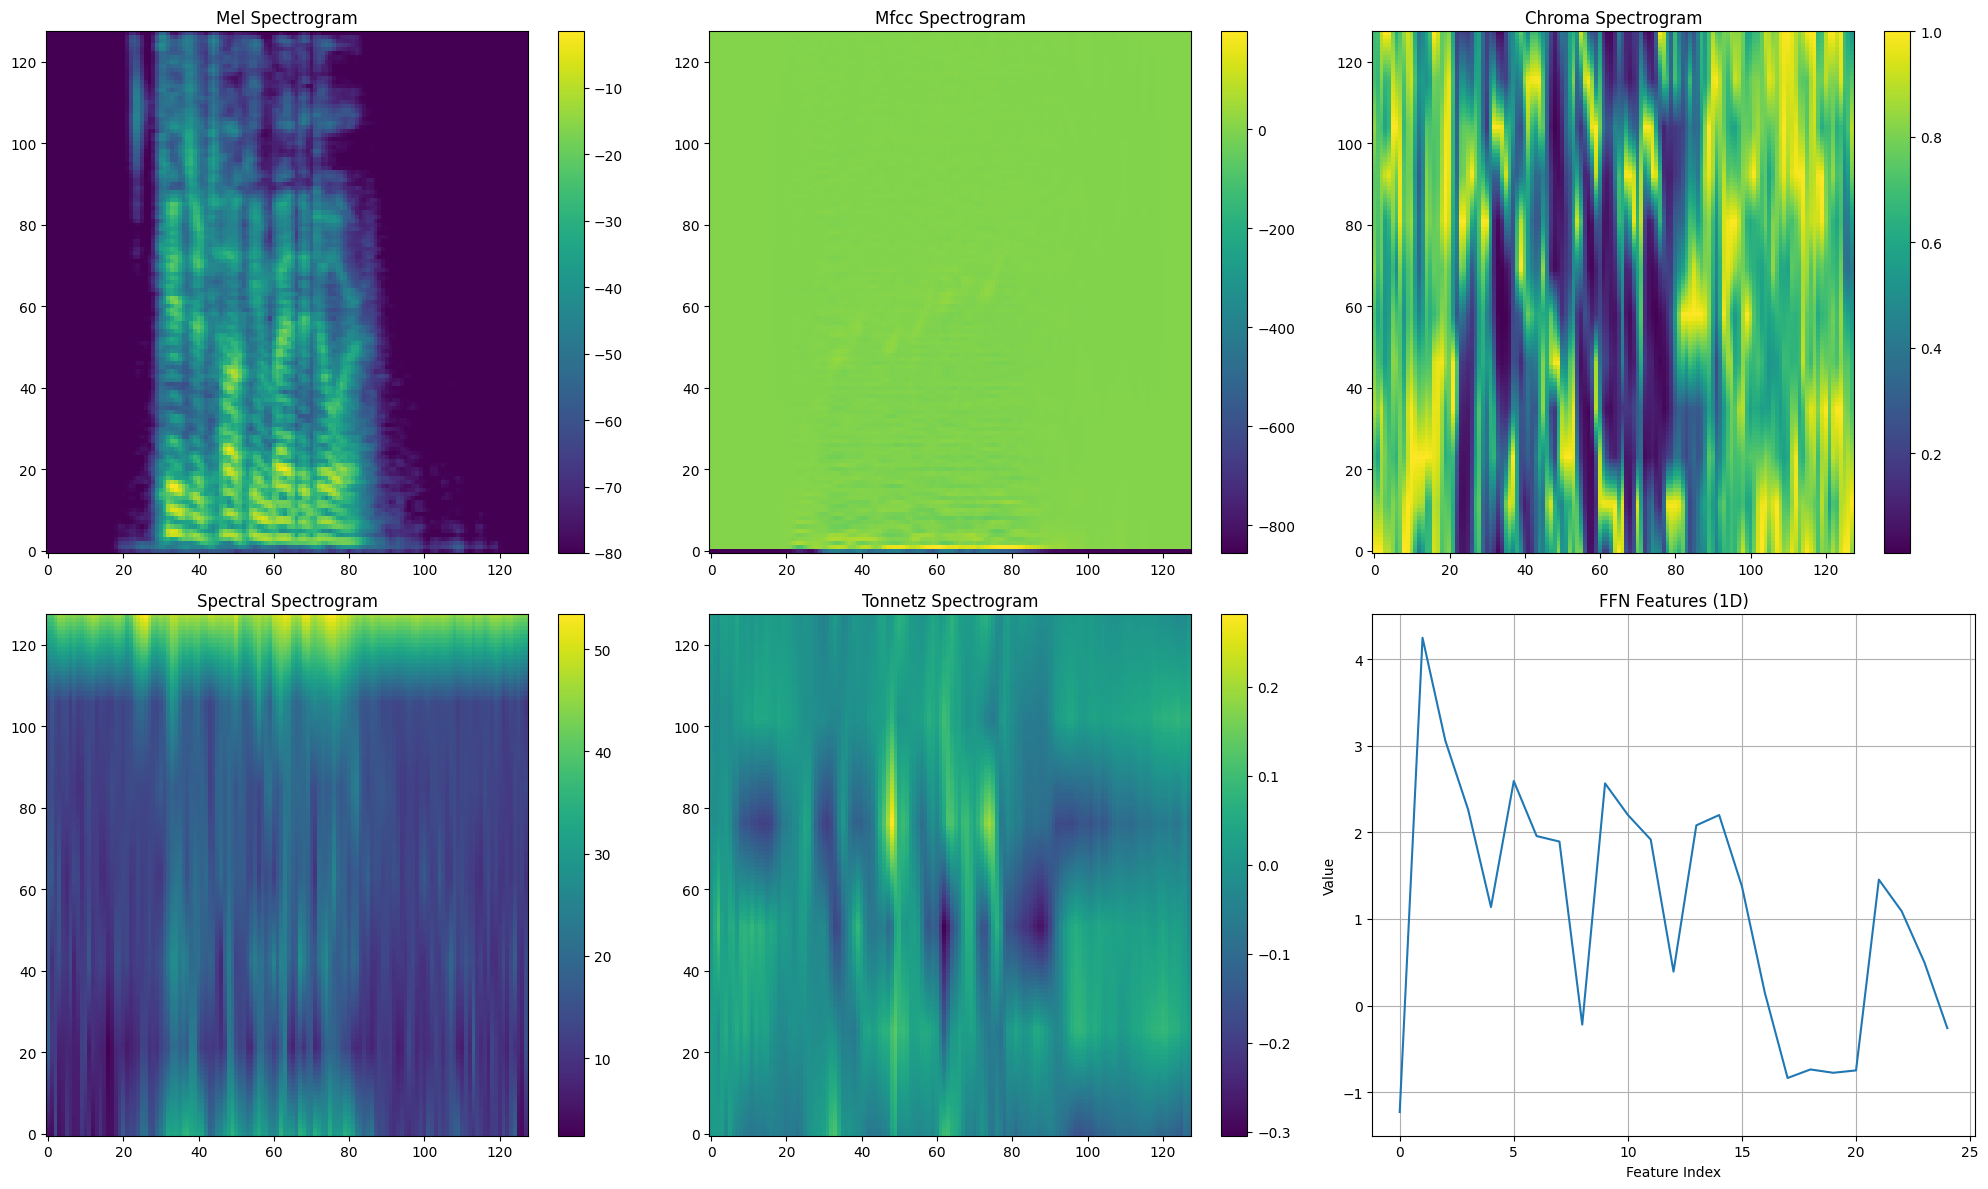


Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_11 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 input_12 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 input_13 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                                  
 input_14 (InputLayer)       [(None, 128, 128, 1)]        0         []                            
                                                                                           

KeyboardInterrupt: 

In [12]:

# %%
# Example usage with dataset

# Load your dataset
data_df=pd.read_csv(r"data\afterReadingDataSet.csv")  # Replace with your dataset path
print(f"Dataset loaded: {len(data_df)} files")

# Test with first file
if test_multi_input_extraction(data_df.Path.iloc[0]):
    print("Ready to process full dataset!")
    
    # Process full dataset
    features_dict, labels, scaler = process_dataset(data_df)
    
    # Visualize features
    visualize_multi_input_features(features_dict, sample_idx=0)
    
    # Train model
    model, history, label_encoder = train_multi_input_model(features_dict, labels)
    
    # Save model and preprocessing objects
    model.save('multi_input_cnn_model.h5')
    
    import pickle
    with open('scaler.pkl', 'wb') as f:
        pickle.dump(scaler, f)
    with open('label_encoder.pkl', 'wb') as f:
        pickle.dump(label_encoder, f)
    
    print("Training complete! Model and preprocessors saved.")
